In [117]:
import numpy as np
from collections import defaultdict
import copy

from agent import Agent

In [328]:
class MonteCarloTreeSearchNode():
    def __init__(self, state, player, parent=None, parent_action=None, num_sims=100):
        self.state = state
        self.player = player
        self.parent = parent
        self.parent_action = parent_action
        self.children = []
        self._number_of_visits = 0
        self._results = defaultdict(int)
        self._results[1] = 0
        self._results[-1] = 0
        self._untried_actions = None
        self._untried_actions = self.untried_actions()
        self.num_sims = num_sims
        return
    
    def untried_actions(self):
        self._untried_actions = list(self.state.get_legal_moves())
        return self._untried_actions

    def q(self):
        wins = self._results[1]
        loses = self._results[-1]
        return wins - loses
    
    def n(self):
        return self._number_of_visits
    
    def expand(self):
        action = self._untried_actions.pop()
        board_copy = copy.deepcopy(self.state)
        board_copy.place(action)
        child_node = MonteCarloTreeSearchNode(
            board_copy, self.player, parent=self, parent_action=action
        )

        self.children.append(child_node)
        return child_node
    
    def is_terminal_node(self):
        return self.state.get_winner() != 0 or len(list(self.state.get_legal_moves())) == 0
    
    def rollout(self):
        current_rollout_state = copy.deepcopy(self.state)

        while current_rollout_state.get_winner() == 0 and len(list(current_rollout_state.get_legal_moves())) > 0:

            possible_moves = list(current_rollout_state.get_legal_moves())

            action = self.rollout_policy(possible_moves)
            current_rollout_state.place(action)
            
        winner = current_rollout_state.get_winner()
        if winner == self.player:
            return 1
        elif winner == -self.player:
            return -1
        else:
            return 0 
    
    def backpropagate(self, result):
        self._number_of_visits += 1.
        self._results[result] += 1.
        if self.parent:
            self.parent.backpropagate(result)
    
    def is_fully_expanded(self):
        return len(self._untried_actions) == 0

    def best_child(self, c_param=0.1):
        choices_weights = [(c.q() / c.n()) + c_param * np.sqrt((2 * np.log(self.n()) / c.n())) for c in self.children]
        if len(choices_weights) == 0:
            print(self.is_terminal_node())
        return self.children[np.argmax(choices_weights)]
    
    def rollout_policy(self, possible_moves):
        return list(possible_moves)[np.random.randint(len(possible_moves))]

    def _tree_policy(self):
        current_node = self
        while not current_node.is_terminal_node():

            if not current_node.is_fully_expanded():
                return current_node.expand()
            else:
                current_node = current_node.best_child()
        return current_node
    
    def best_action(self):
        simulation_no = self.num_sims

        for i in range(simulation_no):

            v = self._tree_policy()
            reward = v.rollout()
            v.backpropagate(reward)

        return self.best_child(c_param=0.1)

In [272]:
class MonteCarloAgent(Agent):
    def __init__(self, name='MctsAgent', num_sims=100):
        super().__init__(name)
        self.name = name
        self.num_sims = num_sims
    
    def evaluate(self, board):
        player = board.current_player
        return MonteCarloTreeSearchNode(board, player, num_sims=self.num_sims).best_action().parent_action

In [273]:
from tictactoe import Board2D
from agent import RandomAgent
from sim import simulate
import matplotlib.pyplot as plt

## MCTS vs. Random, simulation depth exp

In [274]:
x = Board2D()

In [322]:
results = []
rand = RandomAgent()
mct = [10,100,1000]
for mcts_sims in mct:
    mcts = MonteCarloAgent(num_sims=int(mcts_sims))
    res = simulate(x, mcts, rand, num_sims=100, display=False)
    print(res)
    results.append(res)

{'draw': 40, 'MctsAgent': 40, 'RandomAgent': 20}
{'draw': 35, 'MctsAgent': 42, 'RandomAgent': 23}
{'draw': 39, 'MctsAgent': 48, 'RandomAgent': 13}


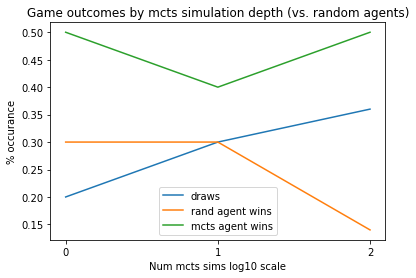

In [314]:
sim_values = [list(x.values()) for x in results]
draws = [x[0]/sum(x) for x in sim_values] # get percentage
rand1_winrate = [x[2]/sum(x) for x in sim_values]
agent_winrate = [x[1]/sum(x) for x in sim_values]

plt.plot(np.log10(mct), draws, label='draws')
plt.plot(np.log10(mct), rand1_winrate, label='rand agent wins')
plt.plot(np.log10(mct), agent_winrate, label='mcts agent wins')
plt.title('Game outcomes by mcts simulation depth (vs. random agents)')
plt.xlabel('Num mcts sims log10 scale')
plt.ylabel('% occurance')
plt.xticks(np.log10(mct))
plt.legend()

Notes:

- Simulation depth seems to have a sizable imapct on performance, i.e. the random agent gets its winrate halved when you multiply the simulations by 100.

## Testing board dims

In [234]:
results = []
rand = RandomAgent()
mcts = MonteCarloAgent(num_sims=100)
for board_dim in range(3,6):
    x = Board2D(board_size=board_dim)
    res = simulate(x, mcts, rand, num_sims=100, display=False)
    print(res)
    results.append(res)

{'draw': 36, 'MctsAgent': 48, 'RandomAgent': 16}
{'draw': 63, 'MctsAgent': 37, 'RandomAgent': 0}
{'draw': 60, 'MctsAgent': 40, 'RandomAgent': 0}


Despite the game result biasing more towards draws with a larger game board, the MCTS agent just on 100 rollouts (this is very low depth) is able to consistenly win.

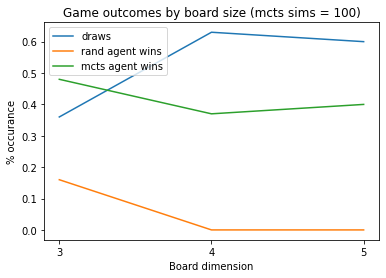

In [236]:
sim_values = [list(x.values()) for x in results]
draws = [x[0]/sum(x) for x in sim_values] # get percentage
rand1_winrate = [x[2]/sum(x) for x in sim_values]
agent_winrate = [x[1]/sum(x) for x in sim_values]

plt.plot(list(range(3,6)), draws, label='draws')
plt.plot(list(range(3,6)), rand1_winrate, label='rand agent wins')
plt.plot(list(range(3,6)), agent_winrate, label='mcts agent wins')
plt.title('Game outcomes by board size (mcts sims = 100)')
plt.xlabel('Board dimension')
plt.ylabel('% occurance')
plt.xticks(list(range(3,6)))
plt.legend()

It seems that in environments with a larger search space, MCTS is clearly able to best random agents to always achieve a draw or a win.

## Testing against MiniMax

### Fixed MCTS Sims 3x3

To start, we can try varying the minimax depth while keeping the MCTS sims fixed (say, sims=100)

In [361]:
depths = range(0,3)
results = []

mcts = MonteCarloAgent(num_sims=100)
for depth in depths:
    mini = MiniMaxAgent(simple_eval, name='mini',depth=depth)
    res = simulate(x, mcts, mini, num_sims=100, display=False)
    print(res)
    results.append(res)

{'draw': 17, 'MctsAgent': 43, 'mini': 40}
{'draw': 36, 'MctsAgent': 9, 'mini': 55}
{'draw': 27, 'MctsAgent': 7, 'mini': 66}


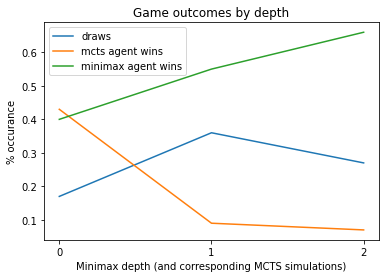

In [365]:
sim_values = [list(x.values()) for x in results]
draws = [x[0]/sum(x) for x in sim_values] # get percentage
mcts_winrate = [x[1]/sum(x) for x in sim_values]
mini_winrate = [x[2]/sum(x) for x in sim_values]

plt.plot(list(depths), draws, label='draws')
plt.plot(list(depths), mcts_winrate, label='mcts agent wins')
plt.plot(list(depths), mini_winrate, label='minimax agent wins')
plt.title('Game outcomes by depth')
plt.xlabel('Minimax depth')
plt.ylabel('% occurance')
plt.xticks(list(depths))
plt.legend()

It seems that even a simple minimax at low depth outclasses our MCTS agent (granted, we are keeping the MCTS simulations relatively low at 100). We can try to formulate a fairer comparison between MCTS and minimax by thinking about how many positions each algorithm sees.

## Variable Sims 3x3

In order to get a (perhaps) better comparison between minimax and mcts, we should evaluate them on how much *time* they use to search. That is, we should find a function $f(n)$ where $n$ is the depth of the minimax that approximates the runtime of an MCTS agent doing $s$ tree searches.

First, we can try to figure out the runtime complexity of minimax as a function of its depth.

A minimax search with depth 1 (on the base 3x3 board) will have just 9 possibilities. If we increase the depth to 2, we'll have 9x8=72 possibilities, i.e. for each of the 9 possible choices we have, there are 8 children nodes (one for each remaining legal move), so we have to search trhough 72 things. A pattern starts to emerge in this analysis: if we have depth 9, we'll go through every possible position in a 3x3 board, i.e. 9! operations. In general, the formula for the number of positions we search through as a function of the depth is as follows:

$$ p_{mini}(n) = \frac{9!}{(9 - n)!}$$ where $n$ is our minimax depth. If we want to generally apply this to all gameboards, we just have to realize that our constant $9$ is related to the dimension of our gameboard, i.e. it's the number of possible moves we have, so if the gameboard is of dimension $d x d$ then our formula becomes $$p_{mini}(n, d) = \frac{d^2!}{(d^2 - n)!}$$

We can write some code to test this out empirically.

In [246]:
from agent import MiniMaxAgent
from eval_functions import simple_eval
import time

In [247]:
base_board = Board2D()

In [278]:
results = []
for i in range(1,10):
    t = time.time()
    mini = MiniMaxAgent(simple_eval, depth=i) # benchmarking n = 1
    mini.evaluate(base_board)
    time_taken = time.time()-t
    print(time_taken)
    results.append(time_taken)

0.011959075927734375
0.08890390396118164
0.3476717472076416
1.9013240337371826
7.112809896469116
20.64969515800476
41.42945313453674
53.69122385978699
60.63394212722778


Text(0.5, 1.0, 'Compute time vs. depth')

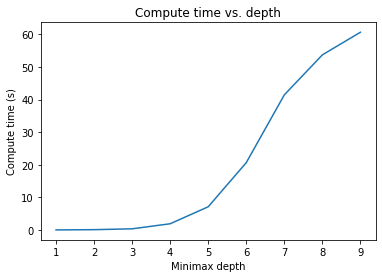

In [281]:
plt.plot(range(1, 10), results)
plt.xlabel('Minimax depth')
plt.ylabel('Compute time (s)')
plt.title('Compute time vs. depth')

In [254]:
def num_pos(n, d=3):
    return np.math.factorial(d**2)/np.math.factorial(d**2 - n)

In [257]:
pos_exact = [num_pos(i) for i in range(1, 10)]

Text(0.5, 1.0, 'Num positions seen vs. depth')

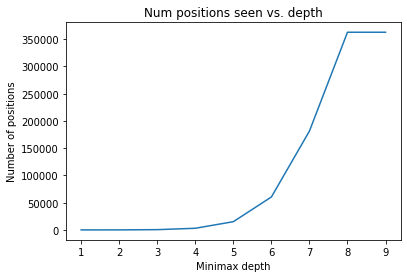

In [259]:
plt.plot(range(1, 10), pos_exact)
plt.xlabel('Minimax depth')
plt.ylabel('Number of positions')
plt.title('Num positions seen vs. depth')

As we can see, empirically the curves look the same, albeit the axes are different because of computational constants. 

Now for MCTS, we first *expand* our tree from the root node and then do a rollout at one of its children. So the number of children we see is 9 positions from the base position (empty 3x3) and then we rollout one of those positions, i.e. we see 9+8 total positions per simulation. In other words, $$p_{mcts}(s) = 17s$$, where $s$ is the number of simulations we have. If we want to expand this to the $d$-dimensional case, we just have to note that we see $(d^2)(d^2-1)$ positions per simulation, so our formula becomes $$p_{mcts}(s, d) = s(d^2)(d^2-1)$$

Now let's look at this empirically.

In [336]:
results = []
s = [i for i in range(1,11)]
for i in s:
    mini = MonteCarloAgent(num_sims=i) # benchmarking n = 1
    t = time.time()
    mini.evaluate(base_board)
    time_taken = time.time()-t
    print(time_taken)
    results.append(time_taken)

0.0014171600341796875
0.0018551349639892578
0.002527952194213867
0.004257917404174805
0.004377126693725586
0.011855840682983398
0.008196115493774414
0.007512092590332031
0.013913869857788086
0.016618967056274414


Text(0.5, 1.0, 'Compute time vs. depth')

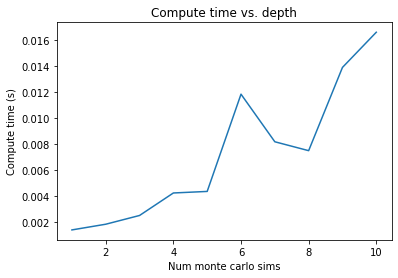

In [337]:
plt.plot(s, results)
plt.xlabel('Num monte carlo sims')
plt.ylabel('Compute time (s)')
plt.title('Compute time vs. depth')

In [338]:
def mcts_p(n, d=3):
    return 17*n

Text(0.5, 1.0, 'Num positions seen vs. mcts simulations')

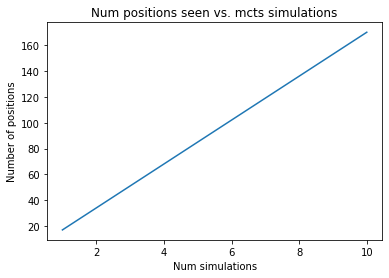

In [355]:
pos_exact = [mcts_p(i) for i in range(1, 11)]
plt.plot(range(1, 11), pos_exact)
plt.xlabel('Num simulations')
plt.ylabel('Number of positions')
plt.title('Num positions seen vs. mcts simulations')

As we can see, there's clearly the linear pattern we predicted, but there's some noisiness because each rollout isn't always going to be the worst-case scenario in terms of # of positions seen.

Now in order to compare our two algorithms, we need to derive an equivalence between $n$ and $s$, i.e. for a given minimax depth, we should chose an $s$ which allows our mcts search to see about as many positions as the minimax. 

In order to do this, we can set $p_{mini} = p_{mcts}$ and find solve for $s$ in terms of $n$, i.e.

$$\frac{9!}{(9-n)!} = 17s \implies s = \frac{9!}{17(9-n)!}$$

From this, we can allow our minimax and MCTS agents to see an equal number of positions. Now we can simulate them head-to-head at various minimax depths.

In [340]:
def sims_from_depth(depth):
    return int(num_pos(depth)/17)

In [366]:
depths = range(2,5)
results = []

for depth in depths:
    mini = MiniMaxAgent(simple_eval, name='mini',depth=depth)
    num_sims = sims_from_depth(depth)
    mcts = MonteCarloAgent(num_sims=num_sims)
    res = simulate(x, mcts, mini, num_sims=100, display=False)
    print(res)
    results.append(res)

{'draw': 2, 'MctsAgent': 2, 'mini': 96}
{'draw': 26, 'MctsAgent': 18, 'mini': 56}
{'draw': 16, 'MctsAgent': 4, 'mini': 80}


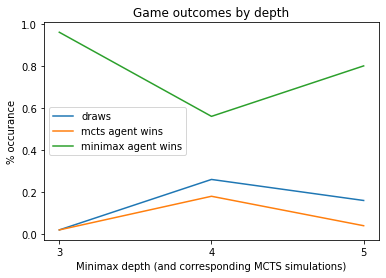

In [367]:
sim_values = [list(x.values()) for x in results]
draws = [x[0]/sum(x) for x in sim_values] # get percentage
mcts_winrate = [x[1]/sum(x) for x in sim_values]
mini_winrate = [x[2]/sum(x) for x in sim_values]

plt.plot(list(range(3,6)), draws, label='draws')
plt.plot(list(range(3,6)), mcts_winrate, label='mcts agent wins')
plt.plot(list(range(3,6)), mini_winrate, label='minimax agent wins')
plt.title('Game outcomes by depth')
plt.xlabel('Minimax depth (and corresponding MCTS simulations)')
plt.ylabel('% occurance')
plt.xticks(list(range(3,6)))
plt.legend()

Note that for depth <= 2, the number of MCTS simulations is basically 0, so we don't show those. It seems that minimax performs better than MCTS if they see the same # of positions. Keep in mind that the eval function is as simple as possible (+/- 100 depending on if the game is won or lost, 0 otherwise) Interestingly, the MCTS improves at first and then its performance decreases when the minimax is given sufficient depth. Perhaps due to the stochastic nature of MCTS it's unable to make as good use of the positions it sees. This is contrasting minimax, which makes much better use of the positions it sees.